# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


---
# Projet H2023 : Prédiction du prix des diamants


La description du projet est disponible à l'adresse suivante : https://www.kaggle.com/t/2126c40a2d454beb8bd36d168581c968

Ce calepin Jupyter de base permet de charger les données fournies. La dernière section détaille la génération du fichier des prédictions afin de le soumettre sur Kaggle dans le bon format.

### Données

Dans un premier temps, vous devrez récupérer les données sur Kaggle. Les fichiers disponibles sont les suivants :
- train.csv
- test.csv

**Déposez ces fichiers dans le répertoire de ce calepin.**

Le fichier *train.csv* contient le prix de vente en dollar américain de 40 455 diamants en fonction des caractéristiques suivantes :

- cut : qualité de coupe (Fair, Good, Very Good, Premium, Ideal)
- color : couleur du diamant (de J (pire) à D (meilleure)
- clarity : clarté du diamant (I1 (pire), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (meilleure))
- x: longueur en mm 
- y: largeur en mm
- z: profondeur en mm
- depth: pourcentage de la profondeur exprimée comme 2*z/(x+y)
- table: pourcentage de la largeur du sommet du diamant par rapport au point le plus large 

Le fichier test.csv contient les caractéristiques de 13 485 diamants pour lesquels vous devriez prédire le prix de vente. La qualité de vos prédictions sera ensuite évaluée lorsque vous les téléverserez sur Kaggle. Vos prédictions seront comparées à celles des autres équipes de la classe.


### Consignes

- Vous devez constituer une équipe de 3 à 5 personnes.
- Au moins une solution doit être proposée sur Kaggle.
- Utilisez votre identifiant d'équipe pour téléverser vos prédictions sur Kaggle.
- Un seul calepin *.ipynb* par équipe doit être remis. Ce fichier documente et illustre la procédure qui vous a permis de produire vos meilleures prédictions. Ce fichier constitue le rapport final du projet.
- Le langage Julia doit être utilisé.
- Votre démarche doit être rigoureusement justifiée (consultez la grille de correction pour vous orienter).

### Quelques conseils

Votre calepin doit permettre à une personne à l'extérieur de l'équipe de comprendre votre démarche et de reproduire vos résultats. Par exemple, une bonne façon de faire consiste à expliquer dans une cellule de texte la tâche qui est accomplie dans la cellule de code suivante. 

Je vous encourage fortement à faire une analyse exploratoire des données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, comme par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se trouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin contient un modèle très simple de prédiction : on n'utilise qu'une seule variable explicative. Ce sera votre travail d'améliorer ces prédictions avec la méthode et les variables de votre choix.

S'il y a des données manquantes, ce sera à vous de traiter ce problème. Vous devriez développer une méthode d'imputation (de remplacement) des données manquantes.

Prenez la peine de documenter succinctement les essais infructueux. Ce n'est pas nécessaire de les expliquer en détails, mais c'est important de les mentionner dans la discussion avec une raison possible de leur échec. De cette façon, une personne qui reprendra votre travail dans le futur ne perdra pas de temps à réessayer une méthode infructueuse déjà testée.

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode a moins bien performée de ce qui était attendu. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données. L'idée est de guider l'analyste qui prendrait la relève de votre travail.

Vous êtes limités à deux soumissions par jour UTC par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs prédictions de la journée.

In [1]:
using CSV 
using DataFrames
using Distributions
using Gadfly
using LinearAlgebra
import Random
using GLM
using Statistics
import StatsBase
import Plots
import SVR

---
## 1. Chargement de données

In [2]:
data = CSV.read("train.csv", DataFrame)
# first(data, 5)
first(sort(data, [:price], rev=true), 5)

Row,ID,cut,color,clarity,depth,table,price,x,y,z
,Int64,String15?,String1,String7,Float64?,Float64,Int64,Float64,Float64?,Float64
1,4422,Premium,I,VS2,60.9,60.0,18823,8.49,8.46,5.16
2,35311,Ideal,G,SI2,62.6,55.0,18804,8.2,8.13,5.11
3,11882,Premium,I,VS1,60.8,59.0,18795,8.12,8.04,4.91
4,21157,Premium,H,SI1,58.1,60.0,18795,8.37,8.3,4.84
5,8394,Ideal,G,SI2,62.7,54.0,18792,8.28,8.34,5.21


Grâce à `dropmissing`, nous pouvons observer qu'il y a 1994 rangées avec des valeurs manquantes dans le fichier `test.csv`

Nous remplaçons les valeurs de 38.1mm trouvées en y et en z par les valeurs de x de la même rangée. Ces valeurs semblent beaucoup plus plausibles que les valeurs aberrantes initiales, malgré leur 

In [3]:
test = CSV.read("test.csv", DataFrame)
println(nrow(test))
println(nrow(dropmissing(test)))

replace!(test.y, 31.8 => 5.15)
replace!(test.z, 31.8 => 5.15)

first(sort(dropmissing(test), [:y], rev=true), 15)

13485


11491


Row,ID,cut,color,clarity,depth,table,x,y,z
,Int64,String15,String1,String7,Float64,Float64,Float64,Float64,Float64
1,2601,Premium,H,I1,62.1,58.0,9.45,9.38,5.85
2,6290,Fair,H,I1,56.2,62.0,9.53,9.37,5.31
3,2118,Premium,I,SI2,60.1,59.0,9.37,9.32,5.62
4,5909,Good,I,I1,57.0,64.0,9.39,9.31,5.33
5,7997,Premium,G,I1,58.6,60.0,9.12,9.06,5.33
6,5070,Fair,I,I1,65.2,56.0,9.11,9.02,5.91
7,9781,Premium,I,SI2,61.1,59.0,9.04,8.97,5.5
8,5773,Fair,I,SI2,65.7,56.0,9.0,8.95,5.9
9,5054,Premium,J,SI2,59.4,58.0,8.86,8.83,5.25


#### 1.1 Retirer les valeurs aberrantes de l'entrainement
À cette étape, nous supprimons les valeurs aberrantes du dataset que nous nous apprêtons à utiliser (valeurs beaucoup trop grandes, tailles négatives,...) pour l'entrainement du modèle. Cela permet d'éviter que le modèle s'entraine sur des données tronquées et qui pourraient biaiser nos futurs estimations.

Seulement 30 rangées ont des valeurs extrêmes, et nous allons donc négliger ces rangées lors de l'entrainement

In [4]:
println("Avec valeurs aberrantes: $(nrow(data))")
filter!((:x) => (x) -> (3 < x), data)
filter!((:y) => (y) -> ismissing(y) || (0 < y && y < 9.5), data)
filter!((:z) => (z) -> (2 < z && z < 6), data)
println("Sans valeurs aberrantes: $(nrow(data))")

Avec valeurs aberrantes: 40455


Sans valeurs aberrantes: 40425


---
## 2. Analyse exploratoire

Cette section consitue une analyse exploratoire superficielle permettant de se familiariser avec les données. C'est une analyse exploratoire sommaire. Je vous encourage fortement à poursuivre cette analyse.

In [5]:
describe(data)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,ID,20228.3,1,20228.0,40455,0,Int64
2,cut,,Fair,,Very Good,3804,"Union{Missing, String15}"
3,color,,D,,J,0,String1
4,clarity,,I1,,VVS2,0,String7
5,depth,61.7475,42.2,61.8,100.5,2199,"Union{Missing, Float64}"
6,table,57.4649,43.0,57.0,95.0,0,Float64
7,price,3934.35,326,2402.0,18823,0,Int64
8,x,5.73137,3.73,5.7,9.5,0,Float64
9,y,5.7329,3.67,5.71,9.46,2199,"Union{Missing, Float64}"


#### 2.1 Prix en fonction des mesures x y z

In [ ]:
p1 = Plots.plot(data.x, data.price, seriestype=:scatter, label="")
Plots.xlabel!("x (en mm)")
Plots.ylabel!("prix")

p2 = Plots.plot(data.y, data.price, seriestype=:scatter, label="")
Plots.xlabel!("y (en mm)")
Plots.ylabel!("prix")

p3 = Plots.plot(data.z, data.price, seriestype=:scatter, label="")
Plots.xlabel!("z (en mm)")
Plots.ylabel!("prix")

Plots.plot(p1, p2, p3, layout = 3)

#### 2.2 Prix en fonction de la clarté
Cette étape nous permet de voir l'intervalle de prix qu'un diamant peut avoir a une clarté donnée. Cela peut être utile pour entrainer le modèle.

Avec ce graphique, on peut conclure que clarity ne semble pas avoir une forte corrélation avec le prix, car les écarts interquartiles semblent tous similaires.

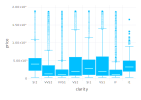

In [7]:
plot(data, x=:clarity, y=:price, Geom.boxplot)

#### 2.3 Distribution des prix

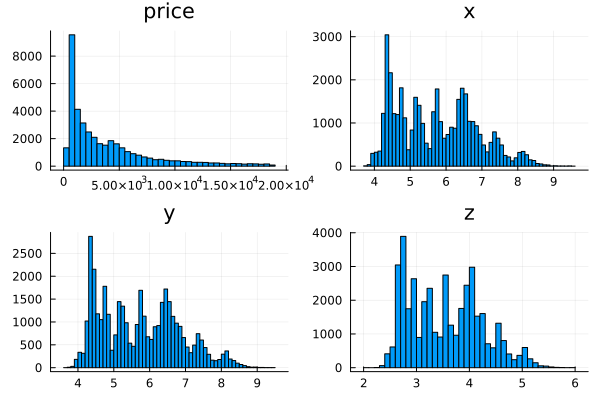

In [8]:
p1 = Plots.histogram(data.price, title="price")
p2 = Plots.histogram(data.x, title="x")
p3 = Plots.histogram(data.y, title="y")
p4 = Plots.histogram(data.z, title="z")
Plots.plot(p1, p2, p3, p4, layout=(2, 2), legend=false)

Nous observons ici que la distribution des prix est distribuée selon une loi de poisson. Cela s'explique par le fait que les meilleurs diamants sont aussi les plus rares, et donc que leur prix est plus élevé.

#### 2.4 Distribution des y

min y = 3.67, max y = 9.46


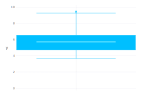

In [9]:
data_without_missing_y = dropmissing(data, :y, disallowmissing=true)
println("min y = $(minimum(data_without_missing_y.y)), max y = $(maximum(data_without_missing_y.y))")

plot(data_without_missing_y, y=:y, Geom.boxplot)

#### 2.5 Affichage de la matrice de covariance

Cette matrice nous permet de savoir quels sont les variables qui ont le plus d'importance dans le prix final du diamant. Dans ce cas précis, il s'agit des variables X, Y et Z

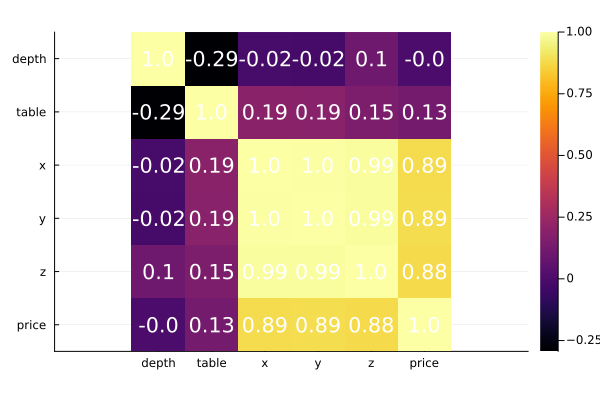

In [10]:
# https://goropikari.github.io/PlotsGallery.jl/src/heatmap.html
labels = [:depth, :table, :x, :y, :z, :price]
# cor(Matrix(select(data, [:table, :x, :z, :price])))
correlation = cor(Matrix(dropmissing(select(data, labels))))
# cor(Matrix(dropmissing(select(data, [:x, :z, :chart, :color_num, :clarity_num, :price]))))

Plots.heatmap(correlation, yflip=true, xticks=(1:6, labels), yticks=(1:6, labels), aspect_ratio=:equal)

ann = [(i,j, Plots.text(round(correlation[i,j], digits=2), :white, :center)) for i in 1:6 for j in 1:6]
Plots.annotate!(ann, linecolor=:white)

---
## 3. Ajustement d'un modèle de régression linéaire

#### 3.1 Normalisation des valeurs

In [ ]:
data.x = StatsBase.standardize(StatsBase.ZScoreTransform, data.x, center=true, scale=true)
data.z = StatsBase.standardize(StatsBase.ZScoreTransform, data.z, center=true, scale=true)

test.x = StatsBase.standardize(StatsBase.ZScoreTransform, test.x, center=true, scale=true)
test.z = StatsBase.standardize(StatsBase.ZScoreTransform, test.z, center=true, scale=true)

#### 3.2 Séparer les données en ensemble d'entrainement/de validation

In [12]:
Random.seed!(3302)

ntrain = round(Int, 0.8 * nrow(data))

train_id = sample(1:nrow(data), ntrain, replace=false, ordered=true)
valid_id = setdiff(1:nrow(data), train_id)

train = data[train_id, :]
valid = data[valid_id, :]

nrow(data), nrow(train), nrow(valid)

(40425, 32340, 8085)

In [13]:
first(train, 5)

Row,ID,cut,color,clarity,depth,table,price,x,y,z
,Int64,String15?,String1,String7,Float64?,Float64,Int64,Float64,Float64?,Float64
1,2,Ideal,G,VVS2,62.7,57.0,1936,-0.54673,5.05,-0.505497
2,3,Premium,E,VVS1,62.0,59.0,1012,-1.25321,4.28,-1.25824
3,4,Ideal,G,VS2,61.7,57.0,720,-1.18167,4.38,-1.20033
4,5,missing,G,VS2,62.4,58.0,6301,0.606885,6.48,0.695993
5,7,Very Good,D,SI1,60.2,61.0,571,-1.19955,4.42,-1.28719


#### 3.3 Fonction qui permet de visualiser les prédictions et les valeurs réelles, permettant de visuellement confirmer la plausibilité des résultats

In [14]:
function plot_predictions(predictions, real_price)
    range = 1:length(predictions)

    df = DataFrame(predictions=predictions, real_price=real_price)
    sort!(df, [:predictions])

    Plots.plot(range, df.real_price[range], seriestype=:scatter, color=:red, label="vérité")
    Plots.plot!(range, df.predictions[range], seriestype=:scatter, color=:blue, label="prédiction")
    Plots.xlabel!("# rangée (en ordre croissant de prédiction de prix)")
    Plots.ylabel!("prix")
end

plot_predictions (generic function with 1 method)

#### 3.4 Prédire les y avec une loi linéaire généralisée gamma

Nous avions précedemment remarqué que le dans le dataset d'entrainemment plusieurs valeurs de Y n'étaient pas présentes, nous avons aisni décidé de prédire celles manquantes. Les données sur la taille des diamants sont extrèmement importantes, il vaut mieux en avoir le plus possible.

In [15]:
y_model = glm(@formula(y ~ color * clarity * table * x * z), train, Gamma(), InverseLink())
train.y = coalesce.(train.y, predict(y_model, train))
valid.y = coalesce.(valid.y, predict(y_model, valid))
test.y = coalesce.(test.y, predict(y_model, test))

# Normaliser la colonne y pour le SVR
train.y = StatsBase.standardize(StatsBase.ZScoreTransform, train.y, center=true, scale=true)
valid.y = StatsBase.standardize(StatsBase.ZScoreTransform, valid.y, center=true, scale=true)
test.y = StatsBase.standardize(StatsBase.ZScoreTransform, test.y, center=true, scale=true)

y_known = dropmissing(train, :y)
y_predictions = predict(y_model, y_known)
y_predictions = collect(skipmissing(y_predictions))

rmse = StatsBase.rmsd(y_known.y, y_predictions)
println("rmse = $(rmse)")

rmse = 5.736101918709229


Les prédictions de y ont un RMSE de 0.065, nous avons donc réussi à prédire les valeurs de y avec une très bonne précision, cela nous sera utile pour l'entrainement final du modèle.

Cette prédiction de y par la régression linéaire nous permet d'éviter de perdre environ 2000 rangées d'entrainement, et cela nous permet aussi de mieux prédire le jeu de données test s'il manque aussi des valeurs de y.

#### 3.5 One hot encoding des variables catégorielles

In [16]:
# https://stackoverflow.com/a/64568113
function one_hot_encoding(df)
    unique_cut = unique(data.cut)
    transform!(df, @. :cut => ByRow(isequal(unique_cut)) .=> Symbol(:cut_, unique_cut))

    unique_color = unique(data.color)
    transform!(df, @. :color => ByRow(isequal(unique_color)) .=> Symbol(:color_, unique_color))

    unique_clarity = unique(data.clarity)
    transform!(df, @. :clarity => ByRow(isequal(unique_clarity)) .=> Symbol(:clarity_, unique_clarity))

    select!(df, Not(:ID))
    select!(df, Not(:cut))
    select!(df, Not(:color))
    select!(df, Not(:clarity))
    select!(df, Not(:depth))
    select!(df, Not(:table))
end

one_hot_encoding(train)
one_hot_encoding(valid)
one_hot_encoding(test)
;

#### 3.6 Convertion en matrices des jeux de données

In [17]:
train_matrix = permutedims(Matrix(select(train, Not(:price))))
valid_matrix = permutedims(Matrix(select(valid, Not(:price))))
test_matrix = permutedims(Matrix(test))
;

#### 3.7 Normalisation des prix

In [ ]:
# https://github.com/madsjulia/SVR.jl
y = Float64.(train.price)
ymin = minimum(y)
ymax = maximum(y)
normalized_y = (y .- ymin) ./ (ymax - ymin)

#### 3.8 Entrainement du modèle SVR

Nous avons initialement essayé un modèle de regression linéaire:
```julia
model = glm(@formula(price ~ color * clarity * x * y * z), train, Poisson(), LogLink())
```
Les `*` signifie que le modèle va utiliser comme variable explicative toutes les combinaisons possibles de ces 5 variables, donnant un total de $(6 + 1) * (7 + 1) * 2^3 = 448$ coefficients (Il y a 6 couleurs possibles + null, 7 clarity possibles + null, et la présence ou l'absence de x, y et z). Avec ce modèle, nous avions réussi d'obtenir `rmse=624.47777`, un peu plus bas que le SVR.

Pour le modèle SVR utilisé, nous définissons le modèle grâce a la méthode SVR.train(). Cette dernière est une méthode destinée à entrainer le modèle SVR (Support Vector Regression). Cette méthode prend plusieurs paramètres. Le paramètre train_matrix correspond à une matrice où chaque ligne est une observation (Dans notre cas, chaque ligne représente les attributs d'un diamant). (Comprend pas normalized_y). Le paramètre kernel_type definit le noyau a utiliser pour l'entrainement. Dans notre cas nous utilisons le noyau à base radiale, RBF (Radial Basis Function).

Cette méthode semblait prometteuse et facile à implémenter, et nous avons donc essayé de l'utiliser grâce à une librairie.

[Wikipedia](https://en.wikipedia.org/wiki/Radial_basis_function_kernel)
[Unlocking the True Power of Support Vector Regression](https://towardsdatascience.com/unlocking-the-true-power-of-support-vector-regression-847fd123a4a0#:~:text=Support%20Vector%20Regression%20is%20a,the%20maximum%20number%20of%20points)

Note: La cellule suivante prend 32 minutes à s'exécuter sur mon laptop (Intel i7-10870H (16) @ 5.000GHz)

In [ ]:
model = SVR.train(normalized_y, train_matrix; kernel_type=SVR.RBF)

SVR.svmmodel(Ptr{SVR.svm_model} @0x000055e7275559c0, SVR.svm_parameter(3, 2, 3, 0.28302585213320525, 0.0, 100.0, 0.001, 1.0, 0, Ptr{Int32} @0x0000000000000000, Ptr{Float64} @0x0000000000000000, 0.1, 0.0001, 1, 0), SVR.svm_problem(32340, Ptr{Float64} @0x000055e7377ee900, Ptr{Ptr{SVR.svm_node}} @0x000055e72b80ffc0), SVR.svm_node[SVR.svm_node(1, -0.546729829735113) SVR.svm_node(1, -1.2532071699498268) … SVR.svm_node(1, -0.7524131060001567) SVR.svm_node(1, -1.369462934795286); SVR.svm_node(2, -0.6160897126769317) SVR.svm_node(2, -1.3089351145673014) … SVR.svm_node(2, -0.7240656194650414) SVR.svm_node(2, -1.3449270834966711); … ; SVR.svm_node(24, 0.0) SVR.svm_node(24, 0.0) … SVR.svm_node(24, 0.0) SVR.svm_node(24, 0.0); SVR.svm_node(-1, NaN) SVR.svm_node(-1, NaN) … SVR.svm_node(-1, NaN) SVR.svm_node(-1, NaN)])

#### 3.9 Enregistrement du modèle dans un fichier

In [ ]:
SVR.savemodel(model, "svr.model")

#### 3.10 Chargement du modèle depuis un fichier

In [21]:
# model = SVR.loadmodel("svr.model")

---
## 4. Estimation du prix de diamants sur les différents ensembles


Dans cette section, nous prédisons la valeur des prix avec le dataset d'entrée, nous arrondissons les résultats obtenus puis nous limitons l'apparition de valeurs aberrantes en utilisant la fonction `clamp()` sur les ensembles de test et de validation. `clamp()` ici permet d'éviter que le modèle explose avec des valeurs aberrantes dans les données de test (par exemple, lors d'une de nos sousmissions antérieures, nous n'avions pas remplacé les 31.8mm dans le jeu de données, et le modèle a prédit des valeurs énormes, gonflant notre rmse à 39691371727.1644)

Nous répétons cette étape sur les 3 jeux de données.

#### 4.1 Prédiction et rmse de l'ensemble d'entrainement

Ceci indique la performance du modèle sur le jeu d'entrainement. Nous pouvons utiliser ce nombre pour savoir si le modèle comme attendu sur le jeu de données de validation.

In [30]:
train_predictions = SVR.predict(model, train_matrix)
train_predictions = round.(Int, train_predictions)

rmse = StatsBase.rmsd(train_predictions, train.price)

5612.904216034114

#### 4.2 Prédiction et rmse de l'ensemble de validation

In [ ]:
valid_predictions = SVR.predict(model, valid_matrix)
predictions = (valid_predictions * (ymax - ymin)) .+ ymin
valid_predictions = round.(Int, valid_predictions)

rmse = StatsBase.rmsd(valid_predictions, valid.price)

In [ ]:
plot_predictions(valid_predictions, valid.price)

#### 4.3 Prédiction et rmse de l'ensemble de test

In [33]:
test_predictions = SVR.predict(model, test_matrix)
test_predictions = (test_predictions * (ymax - ymin)) .+ ymin
test_predictions = round.(Int, test_predictions)
test.price = test_predictions

first(sort(test, [:y], rev=false), 5)

Row,x,y,z,cut_missing,cut_Ideal,cut_Premium,cut_Very Good,cut_Fair,cut_Good,color_E,color_G,color_D,color_I,color_F,color_J,color_H,clarity_SI2,clarity_VVS2,clarity_VVS1,clarity_VS2,clarity_SI1,clarity_VS1,clarity_IF,clarity_I1,price
,Float64,Float64,Float64,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Int64
1,-5.10057,-5.17613,-5.10889,false,false,false,true,false,false,false,false,false,false,false,false,true,false,false,false,true,false,false,false,false,5295
2,-5.10949,-5.15815,-5.10889,false,false,true,false,false,false,false,false,true,false,false,false,false,false,false,true,false,false,false,false,false,5295
3,-5.10057,-5.14018,-5.10889,false,false,false,false,false,true,false,false,false,false,true,false,false,true,false,false,false,false,false,false,false,5295
4,-5.10057,-5.14018,-5.10889,false,false,false,false,false,true,false,false,false,false,true,false,false,true,false,false,false,false,false,false,false,5295
5,-1.71927,-1.76105,-1.64212,false,false,false,true,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,298


#### 4.4 Détecter les prédictions aberrantes et `clamp()` les prédictions

In [34]:
outliers = filter((:price) => price -> price < minimum(data.price) || price > maximum(data.price), test)
clamp!(test_predictions, 0, maximum(data.price))
outliers

Row,x,y,z,cut_missing,cut_Ideal,cut_Premium,cut_Very Good,cut_Fair,cut_Good,color_E,color_G,color_D,color_I,color_F,color_J,color_H,clarity_SI2,clarity_VVS2,clarity_VVS1,clarity_VS2,clarity_SI1,clarity_VS1,clarity_IF,clarity_I1,price
,Float64,Float64,Float64,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Int64
1,2.5988,2.53477,2.76356,false,false,false,true,false,false,false,false,false,false,true,false,false,true,false,false,false,false,false,false,false,19026
2,-1.1929,-1.15891,-1.32433,false,false,false,true,false,false,false,false,false,false,false,true,false,false,false,false,false,true,false,false,false,308
3,1.50144,1.55518,1.60797,true,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,true,false,false,19067
4,-1.63006,-1.60827,-1.61323,false,false,false,true,false,false,false,false,true,false,false,false,false,false,false,false,false,false,true,false,false,307
5,2.15272,2.22022,2.07021,false,false,false,true,false,false,true,false,false,false,false,false,false,false,false,false,false,true,false,false,false,18969
6,2.36684,2.36401,2.44578,false,true,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,true,false,false,false,19060
7,2.30438,2.38199,2.34466,false,true,false,false,false,false,false,false,false,false,false,false,true,false,false,false,false,true,false,false,false,19253
8,2.2687,2.36401,2.18577,false,false,false,true,false,false,false,false,false,false,false,false,true,false,false,false,false,true,false,false,false,19043
9,-1.51408,-1.50941,-1.52656,true,false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,true,false,false,false,260


#### 4.4 Préparation du fichier des préditions pour téléverser sur Kaggle

Le fichier *benchmark_predictions.csv* généré peut être téléversé sur Kaggle. Il est composé d'une colonne d'identifiants (:ID) et d'une colonne de la prédiction des prix (:price).

In [39]:
benchmark_predictions = DataFrame(ID = 1:length(test_predictions), price=test_predictions)
first(benchmark_predictions, 5)

Row,ID,price
,Int64,Int64
1,1,5920
2,2,2755
3,3,2286
4,4,514
5,5,15860


In [40]:
CSV.write("benchmark_predictions.csv", benchmark_predictions)

"benchmark_predictions.csv"

#### 5 - Pistes explorées

Durant le projet nous avons essayé d'implémenter un modèle de régression linéaire et un modèle KNN. Le SVR a mieux prédit que ces 2 modèles, d'ou pourquoi ces deux modèles ne sont pas nos modèles finaux. Cependant, nous utilisons toujours un modèle de régression linéaire afin de prédire y avant de passer le jeu de données dans le SVR.